NeuroPort 3.0

In [2]:
from itertools import compress
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import interpolate
import math
import optuna

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from mne.decoding import UnsupervisedSpatialFilter, SlidingEstimator
from mne.preprocessing.nirs import optical_density, beer_lambert_law, scalp_coupling_index, temporal_derivative_distribution_repair
from mne_nirs.channels import get_long_channels, get_short_channels
from mne_nirs.channels import picks_pair_to_idx as p2idx
from mne_nirs.signal_enhancement import (enhance_negative_correlation,
                                         short_channel_regression)
from mne.viz import plot_compare_evokeds
from mne_nirs.experimental_design import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

import mne
from mne.decoding import Scaler, cross_val_multiscore, Vectorizer
from mne import Epochs, events_from_annotations, set_log_level
from mne.io import read_raw_snirf
from mne_nirs.io.snirf import write_raw_snirf
from mne_bids import write_raw_bids, BIDSPath, read_raw_bids

# Feature extraction
from tsfresh import extract_features, extract_relevant_features, select_features, feature_extraction
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.feature_calculators import set_property
from tsfresh.feature_extraction import feature_calculators

# Feature importance
from eli5.sklearn import PermutationImportance

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

import h5py as h 

In [3]:
def get_id(time):
    time_in_stims = all_stims['time']
    matches = all_stims[(time_in_stims >= time - 30) & (time_in_stims <= time + 5)]
    if len(matches) > 0:
        return matches.iloc[0]['id']
    else:
        return None

In [4]:
def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path, verbose=False)

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(1)
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od = short_channel_regression(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od)
    
    ## FILTERS OUT HEART RATE
    raw_haemo = raw_haemo.filter(None, 0.4,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)
    raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')
    
    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)

    # raw_haemo = get_long_channels(raw_haemo, min_dist=0.01)

    # Pick data channels that are actually informative
    roi_channels = mne.pick_channels(raw_haemo.info['ch_names'], include=['Left_PT','Right_PT'])
    raw_haemo = raw_haemo.copy().pick_channels(roi_channels)

    # Extract events but ignore those with
    events, event_dict = events_from_annotations(raw_haemo, verbose=False,
                                                 regexp='^(?![Ends]).*$')

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-5, tmax=30,
                    reject=dict(hbo=100e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=1,
                    preload=True, verbose=False,event_repeated='merge')

    return raw_haemo, epochs

In [5]:
hbo = pd.DataFrame()
target_all = pd.DataFrame()
n_subs = 10
nearest_decimal = 3

raw_path = r"C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\ses-01\nirs\sub-01_ses-01_task-wings_nirs.snirf"
raw_haemo = read_raw_snirf(raw_path)
hbo_sub_cols = raw_haemo.info.ch_names[::2]


for sub in range(1,n_subs+1):        
    if hbo.empty:
        ev_idx = 0
        last_time = 0
    else:
        ev_idx = hbo['event_index'].max()
        last_time = hbo['time'].max()

    first_ev = True
        
    subject_id = "%02d" % sub
    raw_path = BIDSPath(
        subject="%02d" % sub,
        task='wings',
        session='01',
        datatype="nirs",
        suffix='nirs',
        root=r"C:\Users\dalto\Downloads\project\sourcedata_lm",
        extension=".snirf"
    )

    # raw_haemo = read_raw_bids(raw_path)
    # hbo_sub_cols = raw_haemo.info.ch_names[::2]

    with h.File(raw_path, 'r') as f:
        haemo_multi = f['nirs/data1']
        x_list = list(haemo_multi)
        x_data = haemo_multi.get('dataTimeSeries')
        x_time = np.array(haemo_multi.get('time'))

        hbo_sub_dataset = np.array(x_data[:, ::2])

        stim1 = np.array(f['nirs/stim1/data'])[:,0]
        stim2 = np.array(f['nirs/stim2/data'])[:,0]

        display(x_data)

    hbo_sub = pd.DataFrame(hbo_sub_dataset)

    hbo_sub.rename(columns={old_col: new_col for old_col, new_col in zip(hbo_sub.columns, hbo_sub_cols)}, inplace=True)
    hbo_sub.insert(0, 'time', x_time)

    display(hbo_sub)

    stim1 = pd.DataFrame(stim1)
    stim2 = pd.DataFrame(stim2)

    stim1["id"] = 1
    stim2["id"] = 0
    stim1.rename(columns={stim1.columns[0]: "time"}, inplace=True)
    stim2.rename(columns={stim2.columns[0]: "time"}, inplace=True)
    all_stims = pd.concat([stim1, stim2]).sort_values(by='time')
    
    hbo_sub['id'] = hbo_sub['time'].apply(get_id)
    hbo_sub.insert(1, 'id', hbo_sub.pop('id'))
    hbo_sub.dropna(inplace=True)

    hbo_sub['is_event'] = 0
    for stim_time in all_stims['time']:
        min_diff = np.abs(hbo_sub['time'] - stim_time).idxmin()
        hbo_sub.loc[min_diff, 'is_event'] = 1
    hbo_sub.insert(2, 'is_event', hbo_sub.pop('is_event'))

    event_indices = hbo_sub[hbo_sub['is_event'] == 1].index
    hbo_sub.insert(1, 'event_index', 0)

    for index in event_indices:
        time_of_event = hbo_sub.loc[index, 'time']
        time_before = time_of_event - 5
        if first_ev:
            hbo_sub.loc[hbo_sub['time'] >= time_before, 'event_index'] += ev_idx + 1
            first_ev = False
        else:
            hbo_sub.loc[hbo_sub['time'] >= time_before, 'event_index'] += 1

    hbo_sub['id'] = hbo_sub['id'].astype(int)
    hbo_sub.insert(2, 'sub', sub)

    hbo_sub['time'] = hbo_sub['time'] + last_time

    # set a new target variable equal to the hbo_sub columns event_index, time, sub, and id
    target = hbo_sub[['event_index', 'time', 'sub', 'id']]

    # display(target)
    # display(hbo_sub)

    hbo_sub_by_event = hbo_sub.copy()
    # hbo_sub_by_event.drop_duplicates(subset=['event_index'], inplace=True)

    print(f"\nhbo_by_event shape: {hbo_sub_by_event.shape}")

    hbo = pd.concat([hbo, hbo_sub], axis=0,ignore_index=True)
    target_all = pd.concat([target_all, target], axis=0,ignore_index=True)
    print("NEXT SUB")
    if not sub == n_subs:
        print(sub + 1)
    # hbo_by_event = pd.concat([hbo_by_event, hbo_sub_by_event], axis=0,ignore_index=True)

# replace '760' and '850' with 'hbo' and 'hbr' respectively
hbo.columns = hbo.columns.str.replace('760', 'hbo').str.replace('850', 'hbr')

# sample the hbo data to only include every 10th data point
# hbo = hbo.iloc[::10, :]

columns_to_scale = hbo.columns[5:]

min_value = hbo[columns_to_scale].min()
max_value = hbo[columns_to_scale].max()
hbo[columns_to_scale] = (hbo[columns_to_scale] - min_value) / (max_value - min_value)

display(hbo)
display(target_all)
# display(hbo_by_event)

Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\ses-01\nirs\sub-01_ses-01_task-wings_nirs.snirf


<HDF5 dataset "dataTimeSeries": shape (5830, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.396504,0.122964,0.300707,0.000643,0.278863,0.266423,0.014979,0.005844,0.007002,...,0.004438,0.016127,0.005303,0.005350,0.039963,0.082149,0.001311,0.293435,0.021399,0.017688
1,0.196608,0.396473,0.122967,0.300429,0.000645,0.278575,0.266777,0.014994,0.005875,0.007034,...,0.004463,0.016164,0.005331,0.005419,0.040267,0.082814,0.001326,0.293995,0.021529,0.017751
2,0.393216,0.398045,0.123425,0.301068,0.000643,0.278775,0.267499,0.015072,0.005908,0.007064,...,0.004499,0.016235,0.005388,0.005469,0.040493,0.083457,0.001356,0.294753,0.021684,0.017858
3,0.589824,0.399908,0.124004,0.301869,0.000656,0.279211,0.268729,0.015137,0.005940,0.007122,...,0.004528,0.016386,0.005428,0.005559,0.040858,0.084319,0.001377,0.295934,0.021843,0.018006
4,0.786432,0.401950,0.124587,0.302734,0.000649,0.279721,0.269878,0.015225,0.005946,0.007162,...,0.004502,0.016280,0.005409,0.005410,0.040415,0.082807,0.001324,0.294789,0.021596,0.017839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5825,1145.241600,0.438403,0.132423,0.308176,0.000750,0.276086,0.292358,0.018936,0.007058,0.007423,...,0.004313,0.020094,0.006183,0.006301,0.046457,0.088095,0.001186,0.288960,0.020856,0.017731
5826,1145.438208,0.438634,0.132683,0.308643,0.000745,0.276217,0.293161,0.019033,0.007091,0.007489,...,0.004356,0.020209,0.006276,0.006381,0.046743,0.088676,0.001198,0.289782,0.021026,0.017855
5827,1145.634816,0.439866,0.133191,0.309429,0.000756,0.276603,0.294299,0.019130,0.007137,0.007568,...,0.004373,0.020309,0.006359,0.006510,0.047107,0.089560,0.001215,0.290940,0.021234,0.018052
5828,1145.831424,0.441482,0.133504,0.310352,0.000762,0.276977,0.295377,0.019210,0.007166,0.007617,...,0.004349,0.020177,0.006256,0.006259,0.046613,0.087945,0.001172,0.289930,0.020890,0.017783



hbo_by_event shape: (5649, 51)
NEXT SUB
2


<HDF5 dataset "dataTimeSeries": shape (6251, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.409025,0.225018,0.071813,0.000253,0.235217,0.218571,0.007965,0.004599,0.003749,...,0.002834,0.018030,0.005369,0.010351,0.048165,0.054089,0.000357,0.064499,0.011573,0.045033
1,0.196608,0.411388,0.226462,0.072023,0.000250,0.235872,0.219840,0.008070,0.004663,0.003826,...,0.002865,0.018152,0.005440,0.010481,0.048563,0.054511,0.000361,0.064587,0.011703,0.045368
2,0.393216,0.412890,0.225649,0.071851,0.000252,0.235639,0.217707,0.007889,0.004560,0.003744,...,0.002772,0.017756,0.005258,0.010188,0.047757,0.053635,0.000357,0.064332,0.011298,0.044588
3,0.589824,0.406636,0.223403,0.071446,0.000251,0.234555,0.216708,0.007879,0.004542,0.003750,...,0.002768,0.017659,0.005244,0.010146,0.047521,0.053407,0.000353,0.064160,0.011309,0.044521
4,0.786432,0.406775,0.223667,0.071551,0.000249,0.234947,0.216965,0.007898,0.004552,0.003757,...,0.002818,0.017760,0.005292,0.010191,0.047661,0.053603,0.000354,0.064173,0.011449,0.044718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6246,1228.013568,0.452393,0.257643,0.074893,0.000267,0.257066,0.247974,0.008999,0.005405,0.003807,...,0.002939,0.022925,0.006538,0.011814,0.055742,0.064507,0.000396,0.061616,0.012769,0.049622
6247,1228.210176,0.449124,0.254581,0.074903,0.000270,0.256452,0.250766,0.009175,0.005452,0.003788,...,0.002953,0.023031,0.006729,0.011911,0.058662,0.066190,0.000379,0.061575,0.012809,0.049561
6248,1228.406784,0.449194,0.256704,0.075087,0.000273,0.256400,0.250742,0.009159,0.005468,0.003861,...,0.003013,0.023889,0.006752,0.012147,0.058966,0.066195,0.000387,0.061646,0.012846,0.049610
6249,1228.603392,0.451559,0.261494,0.075686,0.000284,0.260195,0.255048,0.009142,0.005481,0.003915,...,0.003140,0.024198,0.006539,0.012151,0.058363,0.065189,0.000393,0.061778,0.012817,0.049625



hbo_by_event shape: (5811, 51)
NEXT SUB
3


<HDF5 dataset "dataTimeSeries": shape (6023, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.351811,0.109691,0.083203,0.000755,0.297687,0.273206,0.018671,0.003869,0.002083,...,0.004255,0.019021,0.010885,0.020613,0.034619,0.114168,0.000796,0.222977,0.011787,0.048045
1,0.196608,0.353914,0.110043,0.083280,0.000742,0.297861,0.274377,0.018756,0.003907,0.002083,...,0.004278,0.019117,0.010965,0.020560,0.034633,0.114351,0.000800,0.223178,0.011717,0.047686
2,0.393216,0.351262,0.109129,0.083053,0.000743,0.297415,0.272383,0.018566,0.003838,0.002070,...,0.004173,0.018818,0.010578,0.020047,0.034089,0.113001,0.000783,0.222175,0.011498,0.047063
3,0.589824,0.349382,0.108868,0.082840,0.000743,0.296893,0.271771,0.018520,0.003817,0.002045,...,0.004183,0.018813,0.010568,0.020053,0.033998,0.112733,0.000785,0.221727,0.011474,0.047054
4,0.786432,0.349527,0.109000,0.082812,0.000740,0.296782,0.272349,0.018505,0.003853,0.002051,...,0.004199,0.018932,0.010716,0.020228,0.034203,0.113036,0.000792,0.221709,0.011577,0.047317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,1183.186944,0.373147,0.119819,0.081198,0.000836,0.293072,0.312565,0.021630,0.004327,0.002181,...,0.003967,0.020328,0.010929,0.021924,0.036899,0.119276,0.000784,0.199165,0.011117,0.047329
6019,1183.383552,0.367900,0.118903,0.080829,0.000833,0.292375,0.311690,0.021484,0.004321,0.002160,...,0.003972,0.020254,0.010916,0.021895,0.036814,0.118979,0.000781,0.198827,0.011101,0.047110
6020,1183.580160,0.367662,0.118817,0.080708,0.000836,0.292280,0.311745,0.021497,0.004320,0.002170,...,0.003971,0.020338,0.011033,0.022108,0.036979,0.119243,0.000788,0.198971,0.011148,0.047273
6021,1183.776768,0.369103,0.119372,0.080884,0.000826,0.292732,0.312775,0.021630,0.004319,0.002168,...,0.003985,0.020445,0.011190,0.022384,0.037290,0.120000,0.000782,0.199441,0.011267,0.047597



hbo_by_event shape: (5719, 51)
NEXT SUB
4


<HDF5 dataset "dataTimeSeries": shape (6125, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.376143,0.064722,0.260011,0.000589,0.248785,0.262589,0.008121,0.003386,0.002074,...,0.002629,0.022646,0.012911,0.024443,0.099710,0.057587,0.000693,0.495562,0.007803,0.018705
1,0.196608,0.375325,0.064624,0.259630,0.000605,0.248485,0.262452,0.008106,0.003377,0.002086,...,0.002643,0.022664,0.012952,0.024465,0.099801,0.057750,0.000694,0.495361,0.007817,0.018718
2,0.393216,0.375770,0.064992,0.259944,0.000598,0.248763,0.262886,0.008123,0.003400,0.002088,...,0.002655,0.022727,0.013000,0.024555,0.100278,0.058026,0.000701,0.495516,0.007870,0.018805
3,0.589824,0.377438,0.065251,0.260530,0.000598,0.248200,0.263667,0.008167,0.003419,0.002090,...,0.002656,0.022820,0.013075,0.024729,0.100755,0.058360,0.000703,0.495794,0.007886,0.018908
4,0.786432,0.378902,0.065670,0.261137,0.000605,0.248698,0.264603,0.008206,0.003414,0.002121,...,0.002684,0.022957,0.013178,0.024891,0.101403,0.058843,0.000706,0.496169,0.007964,0.019017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120,1203.240960,0.353233,0.064820,0.251693,0.000623,0.263908,0.279509,0.010032,0.003830,0.002000,...,0.002476,0.023002,0.014124,0.024259,0.101482,0.064351,0.000667,0.490708,0.007276,0.018262
6121,1203.437568,0.355440,0.065407,0.252547,0.000612,0.264212,0.280350,0.010035,0.003843,0.002017,...,0.002507,0.023025,0.014169,0.024309,0.101807,0.064856,0.000664,0.491192,0.007330,0.018405
6122,1203.634176,0.358150,0.065919,0.253339,0.000628,0.264432,0.281072,0.010001,0.003875,0.002045,...,0.002544,0.023033,0.014237,0.024409,0.102389,0.065333,0.000671,0.491915,0.007409,0.018556
6123,1203.830784,0.361584,0.066662,0.254494,0.000630,0.264503,0.282191,0.010077,0.003898,0.002064,...,0.002563,0.023031,0.014193,0.024381,0.102358,0.064687,0.000677,0.492785,0.007369,0.018497



hbo_by_event shape: (5758, 51)
NEXT SUB
5


<HDF5 dataset "dataTimeSeries": shape (6035, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.371982,0.066923,0.225492,0.000274,0.274991,0.240354,0.003939,0.001583,0.002064,...,0.002081,0.026869,0.006650,0.005486,0.106954,0.067143,0.000415,0.165480,0.011476,0.031877
1,0.196608,0.373665,0.067249,0.226048,0.000280,0.275791,0.241314,0.003959,0.001590,0.002075,...,0.002093,0.026914,0.006662,0.005490,0.106909,0.067044,0.000420,0.165619,0.011247,0.031692
2,0.393216,0.371359,0.066461,0.225246,0.000274,0.274233,0.239449,0.003927,0.001574,0.002044,...,0.002054,0.026574,0.006545,0.005433,0.105789,0.066477,0.000410,0.164842,0.011174,0.031466
3,0.589824,0.369695,0.066354,0.224705,0.000272,0.273814,0.239401,0.003918,0.001565,0.002039,...,0.002052,0.026566,0.006581,0.005430,0.105820,0.066421,0.000408,0.164790,0.011191,0.031450
4,0.786432,0.369783,0.066500,0.224833,0.000275,0.274174,0.239644,0.003927,0.001580,0.002059,...,0.002058,0.026711,0.006616,0.005456,0.106506,0.066729,0.000410,0.164852,0.011333,0.031577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6030,1185.546240,0.392869,0.070681,0.245020,0.000283,0.267242,0.260103,0.004495,0.001726,0.002108,...,0.002001,0.030644,0.006858,0.006004,0.118884,0.072822,0.000420,0.153617,0.010656,0.028262
6031,1185.742848,0.387956,0.069342,0.243116,0.000290,0.265507,0.257742,0.004458,0.001722,0.002093,...,0.001982,0.030545,0.006833,0.005972,0.118289,0.072405,0.000417,0.153171,0.010627,0.028105
6032,1185.939456,0.387423,0.069433,0.242869,0.000285,0.265211,0.257686,0.004482,0.001709,0.002078,...,0.001991,0.030594,0.006862,0.005976,0.118478,0.072490,0.000420,0.153058,0.010717,0.028238
6033,1186.136064,0.388391,0.069610,0.243015,0.000284,0.265616,0.258354,0.004477,0.001730,0.002103,...,0.002020,0.030822,0.006933,0.006042,0.119308,0.072871,0.000427,0.153233,0.010872,0.028504



hbo_by_event shape: (5840, 51)
NEXT SUB
6


<HDF5 dataset "dataTimeSeries": shape (6236, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.375063,0.431252,0.206994,0.000681,0.330079,0.244426,0.006544,0.003009,0.002165,...,0.004550,0.034018,0.006075,0.008959,0.075344,0.046214,0.000646,0.091570,0.009288,0.015481
1,0.196608,0.374172,0.431027,0.206516,0.000692,0.329761,0.244056,0.006615,0.003019,0.002173,...,0.004564,0.033866,0.006058,0.008955,0.075272,0.046219,0.000634,0.091519,0.009314,0.015523
2,0.393216,0.375019,0.433946,0.207086,0.000683,0.330125,0.244546,0.006698,0.003052,0.002184,...,0.004603,0.033994,0.006061,0.009001,0.075757,0.046433,0.000651,0.091590,0.009430,0.015626
3,0.589824,0.377328,0.437428,0.207849,0.000691,0.331077,0.245505,0.006780,0.003091,0.002190,...,0.004645,0.034111,0.006107,0.009083,0.076250,0.046824,0.000645,0.091894,0.009581,0.015757
4,0.786432,0.379365,0.441377,0.209009,0.000705,0.332092,0.246457,0.006802,0.003086,0.002215,...,0.004560,0.033771,0.006039,0.008944,0.075195,0.046185,0.000641,0.091552,0.009315,0.015519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6231,1225.064448,0.394545,0.462657,0.217269,0.000721,0.335821,0.271751,0.007061,0.003341,0.002231,...,0.004838,0.041318,0.007144,0.010776,0.091013,0.052664,0.000682,0.090298,0.010204,0.017297
6232,1225.261056,0.396391,0.465733,0.218112,0.000716,0.336329,0.272106,0.006934,0.003281,0.002218,...,0.004772,0.040939,0.007052,0.010629,0.089562,0.051692,0.000655,0.089942,0.009757,0.016860
6233,1225.457664,0.391282,0.457437,0.216210,0.000699,0.334744,0.269979,0.006812,0.003224,0.002185,...,0.004759,0.040734,0.007028,0.010605,0.089050,0.051496,0.000657,0.089760,0.009743,0.016794
6234,1225.654272,0.390432,0.457142,0.216132,0.000699,0.334319,0.269780,0.006865,0.003267,0.002204,...,0.004753,0.040635,0.007021,0.010622,0.089285,0.051654,0.000663,0.089862,0.009850,0.016922



hbo_by_event shape: (5976, 51)
NEXT SUB
7


<HDF5 dataset "dataTimeSeries": shape (6042, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.368901,0.108615,0.301157,0.000708,0.234178,0.236762,0.008867,0.002488,0.005036,...,0.002745,0.021233,0.007931,0.009588,0.123557,0.034927,0.000591,0.156235,0.013096,0.037032
1,0.196608,0.370934,0.109363,0.302138,0.000710,0.234536,0.237306,0.008881,0.002496,0.005048,...,0.002728,0.021040,0.007806,0.009450,0.122585,0.034525,0.000584,0.155810,0.012737,0.036536
2,0.393216,0.365211,0.107390,0.298673,0.000698,0.233360,0.235055,0.008751,0.002478,0.004982,...,0.002703,0.020921,0.007741,0.009398,0.121723,0.034318,0.000569,0.155510,0.012684,0.036271
3,0.589824,0.363880,0.107131,0.298057,0.000707,0.233148,0.234933,0.008712,0.002444,0.004993,...,0.002706,0.020876,0.007748,0.009406,0.121569,0.034346,0.000569,0.155321,0.012727,0.036402
4,0.786432,0.364676,0.107436,0.298597,0.000697,0.233197,0.235119,0.008756,0.002464,0.005011,...,0.002712,0.020904,0.007784,0.009447,0.121946,0.034450,0.000578,0.155512,0.012817,0.036502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6037,1186.922496,0.373360,0.112501,0.303933,0.000812,0.246824,0.268564,0.010292,0.003092,0.005369,...,0.002723,0.026111,0.009189,0.011739,0.152895,0.045187,0.000632,0.148652,0.013579,0.040319
6038,1187.119104,0.376779,0.111741,0.304975,0.000820,0.247649,0.268970,0.010370,0.003130,0.005374,...,0.002690,0.025925,0.009110,0.011590,0.151572,0.044919,0.000624,0.148660,0.013187,0.039463
6039,1187.315712,0.376446,0.109491,0.303002,0.000799,0.247199,0.266665,0.010313,0.003113,0.005285,...,0.002668,0.025449,0.009038,0.011419,0.149662,0.044423,0.000618,0.148555,0.013102,0.039224
6040,1187.512320,0.374917,0.109481,0.302889,0.000811,0.247254,0.266001,0.010324,0.003139,0.005302,...,0.002676,0.025215,0.008991,0.011398,0.149826,0.044075,0.000628,0.148715,0.013291,0.039743



hbo_by_event shape: (5871, 51)
NEXT SUB
8


<HDF5 dataset "dataTimeSeries": shape (5909, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.378544,0.142305,0.322747,0.000837,0.311623,0.281413,0.013993,0.004192,0.003362,...,0.003195,0.032320,0.015878,0.009871,0.043725,0.045826,0.000337,0.116557,0.005904,0.019002
1,0.196608,0.380458,0.142726,0.323269,0.000834,0.312133,0.282118,0.014083,0.004224,0.003379,...,0.003207,0.032483,0.015980,0.009972,0.044073,0.046109,0.000342,0.116797,0.005968,0.019184
2,0.393216,0.382642,0.143420,0.324106,0.000835,0.312700,0.283061,0.014155,0.004256,0.003410,...,0.003204,0.032305,0.015831,0.009841,0.043817,0.045786,0.000335,0.116766,0.005857,0.018968
3,0.589824,0.377801,0.142067,0.322787,0.000832,0.311937,0.281258,0.013903,0.004189,0.003313,...,0.003161,0.032099,0.015715,0.009784,0.043461,0.045632,0.000338,0.116457,0.005825,0.018813
4,0.786432,0.376517,0.141627,0.322152,0.000835,0.311585,0.280498,0.013918,0.004171,0.003322,...,0.003164,0.032020,0.015678,0.009758,0.043399,0.045583,0.000333,0.116357,0.005829,0.018818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,1160.773632,0.349901,0.145555,0.327479,0.000876,0.281572,0.288995,0.015964,0.004676,0.003648,...,0.003045,0.025159,0.013825,0.008820,0.041839,0.044643,0.000328,0.115437,0.005487,0.018010
5905,1160.970240,0.352329,0.146187,0.328514,0.000890,0.282359,0.289850,0.016079,0.004697,0.003698,...,0.003076,0.025416,0.014036,0.008958,0.042213,0.045083,0.000331,0.115683,0.005585,0.018275
5906,1161.166848,0.355553,0.147258,0.329583,0.000899,0.283240,0.291430,0.016281,0.004764,0.003762,...,0.003099,0.025505,0.014057,0.008900,0.042077,0.044818,0.000331,0.115806,0.005469,0.017997
5907,1161.363456,0.351541,0.145939,0.328599,0.000895,0.282583,0.289246,0.016058,0.004691,0.003638,...,0.003007,0.025097,0.013876,0.008786,0.041591,0.044389,0.000323,0.115417,0.005403,0.017872



hbo_by_event shape: (5706, 51)
NEXT SUB
9


<HDF5 dataset "dataTimeSeries": shape (5795, 92), type "<f8">

,time,S1_D1 760,S3_D1 760,S3_D15 760,S4_D2 760,S4_D16 760,S5_D4 760,S6_D3 760,S6_D5 760,S6_D7 760,...,S11_D9 850,S12_D8 850,S12_D10 850,S13_D10 850,S13_D12 850,S14_D11 850,S14_D13 850,S14_D21 850,S15_D14 850,S16_D14 850
0,0.000000,0.410107,0.112604,0.310840,0.001540,0.289303,0.277226,0.013476,0.003048,0.001079,...,0.000916,0.019204,0.009508,0.005317,0.096137,0.015128,0.000563,0.048826,0.003694,0.007633
1,0.196608,0.410378,0.112885,0.311021,0.001532,0.289264,0.277200,0.013569,0.003038,0.001068,...,0.000934,0.019284,0.009575,0.005354,0.096649,0.015279,0.000559,0.048998,0.003746,0.007709
2,0.393216,0.413244,0.113984,0.312556,0.001548,0.290065,0.278578,0.013711,0.003070,0.001086,...,0.000928,0.019419,0.009654,0.005403,0.097412,0.015432,0.000572,0.049172,0.003781,0.007805
3,0.589824,0.416179,0.114945,0.314187,0.001564,0.290946,0.279725,0.013843,0.003076,0.001091,...,0.000946,0.019513,0.009690,0.005417,0.097406,0.015345,0.000566,0.049156,0.003739,0.007776
4,0.786432,0.412009,0.112968,0.311580,0.001528,0.289804,0.276627,0.013476,0.003030,0.001072,...,0.000931,0.019127,0.009471,0.005290,0.095709,0.015078,0.000556,0.048862,0.003659,0.007620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790,1138.360320,0.435424,0.120519,0.313959,0.001704,0.297024,0.315757,0.015099,0.003527,0.001163,...,0.000956,0.026051,0.011665,0.006817,0.116383,0.016921,0.000577,0.045536,0.003744,0.007395
5791,1138.556928,0.433730,0.120452,0.313117,0.001693,0.296615,0.314640,0.015076,0.003508,0.001164,...,0.000950,0.026030,0.011662,0.006812,0.115827,0.016928,0.000575,0.045533,0.003758,0.007407
5792,1138.753536,0.434327,0.120814,0.313393,0.001682,0.296779,0.315159,0.015106,0.003540,0.001170,...,0.000955,0.026139,0.011745,0.006862,0.116275,0.017055,0.000586,0.045648,0.003810,0.007500
5793,1138.950144,0.436676,0.121468,0.314327,0.001711,0.297366,0.315742,0.015127,0.003536,0.001169,...,0.000948,0.026009,0.011647,0.006786,0.115261,0.016797,0.000571,0.045452,0.003699,0.007332


KeyboardInterrupt: 

In [ ]:
# all_stims = pd.DataFrame()

# for sub in range(1,n_subs+1):
#     subject_id = "%02d" % sub
#     raw_path = BIDSPath(
#         subject="%02d" % sub,
#         task="wings",
#         session='01',
#         datatype="nirs",
#         suffix='nirs',
#         root=r"C:\Users\dalto\Downloads\project\sourcedata_lm",
#         extension=".snirf"
#     )

#     with h.File(raw_path,'r') as f:
#         stim1 = np.array(f['nirs/stim1/data'])[:,0]
#         stim2 = np.array(f['nirs/stim2/data'])[:,0]

#     stim1 = pd.DataFrame(stim1)
#     stim2 = pd.DataFrame(stim2)

#     stim1["id"] = 1
#     stim2["id"] = 0
#     stim1.rename(columns={stim1.columns[0]: "time"}, inplace=True)
#     stim2.rename(columns={stim2.columns[0]: "time"}, inplace=True)
#     stims = pd.concat([stim1, stim2]).sort_values(by='time')
    
#     # display(stims)

#     stims['time'] = stims['time'].round(nearest_decimal)
#     all_stims = pd.concat([all_stims,stims],axis=0,ignore_index=True)
#     all_stims.index = range(1, len(all_stims) + 1)

# # Your previous code to modify 'all_stims' DataFrame
# time_before = 5.0
# time_increase = 30

# greater_times = all_stims['time'][all_stims['time'] > all_stims['time'].shift(-1)]
# greater_indices = all_stims[all_stims['time'].isin(greater_times)].index

# for time,idx in zip(greater_times,greater_indices):
#     all_stims.loc[(idx+1):, 'time'] += time + time_increase

# display(all_stims[38:42])

In [ ]:
# greater_indices = []
# greater_times = []

# # create a list that saves the last hbo['time'] index before 'time' decreases
# greater_times = hbo['time'][hbo['time'] > hbo['time'].shift(-1)]
# greater_indices = hbo[hbo['time'].isin(greater_times)].index

# display(hbo.head())

# for time,idx in zip(greater_times,greater_indices):
#     hbo.loc[(idx+1):, 'time'] += time + time_increase

# print(hbo[hbo['id'] == 1].shape)
# print(hbo[hbo['id'] == 0].shape)

# hbo.dropna(inplace=True)

# display(hbo)

In [ ]:
# hbo_values = pd.DataFrame()

# hbo['event_index'] = 1
# hbo.dropna(inplace=True)
# print(hbo.shape)
# event_index = 1
# desired_times = []

# for time in all_stims['time']:
#     desired_times = (hbo['time'] >= time - 5) & (hbo['time'] <= time + 30)
#     hbo_subset = hbo[desired_times]
#     print(time)
#     # display(hbo_subset)
#     if not hbo_subset.empty:
#         closest_time_index = hbo_subset['time'].sub(time).abs().idxmin()
#         # hbo.loc[closest_time_index, 'is_event'] = 1
#         hbo.loc[closest_time_index:, 'event_index'] = event_index  # Set subsequent 'event_index' rows to the most recent event index value
#         event_index += 1  # Increment the event index variable
#         hbo_values = pd.concat([hbo_values, hbo_subset], axis=0, ignore_index=True)
#         hbo_values['event_index'] = hbo_values['event_index'].astype(int)

#     if hbo_sub.empty:
#         display(hbo_sub)

# hbo['event_index'] = hbo_values['event_index']
# hbo.drop('is_event',axis=1,inplace=True)
# display(hbo)

In [ ]:
# Create a mapping dictionary for event_index to id
# mapping = dict(zip(target_all.index, target_all['id']))

# Apply the mapping to the 'event_index' column in 'hbo'
# hbo['id'] = hbo['event_index'].map(mapping)
# hbo.set_index('event_index', inplace=True)
# hbo.drop('time', axis=1, inplace=True)

display(hbo)

,time,event_index,sub,id,is_event,S1_D1 hbo,S3_D1 hbo,S3_D15 hbo,S4_D2 hbo,S4_D16 hbo,...,S11_D9 hbr,S12_D8 hbr,S12_D10 hbr,S13_D10 hbr,S13_D12 hbr,S14_D11 hbr,S14_D13 hbr,S14_D21 hbr,S15_D14 hbr,S16_D14 hbr
0,34.799616,1,1,1,0,0.486129,0.147449,0.894154,0.212543,0.427141,...,0.842637,0.021050,0.050091,0.103644,0.083923,0.565823,0.936886,0.561429,0.887124,0.222351
1,34.996224,1,1,1,0,0.455527,0.145235,0.887502,0.205574,0.423054,...,0.838482,0.015478,0.046911,0.101001,0.081361,0.563464,0.932054,0.559945,0.885574,0.221580
2,35.192832,1,1,1,0,0.455354,0.145132,0.885731,0.211005,0.420939,...,0.841045,0.015287,0.048024,0.102180,0.081874,0.566126,0.933335,0.560351,0.889187,0.221627
3,35.389440,1,1,1,0,0.465135,0.145882,0.888122,0.207707,0.422940,...,0.845375,0.017499,0.050051,0.105381,0.083398,0.571348,0.955432,0.561829,0.896662,0.223785
4,35.586048,1,1,1,0,0.477394,0.146733,0.891064,0.213257,0.426535,...,0.852847,0.022255,0.055005,0.109020,0.086131,0.577280,0.978519,0.564092,0.904457,0.226539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57655,11776.819200,400,10,0,0,0.770604,0.628960,0.904119,0.786019,0.696918,...,0.610977,0.431417,0.100759,0.025688,0.091759,0.008832,0.021847,0.000048,0.323619,0.099478
57656,11777.015808,400,10,0,0,0.787923,0.635775,0.908618,0.784462,0.691457,...,0.604251,0.439781,0.100828,0.023465,0.093622,0.007968,0.014238,0.000034,0.315217,0.095622
57657,11777.212416,400,10,0,0,0.752859,0.616072,0.900225,0.797843,0.719392,...,0.591739,0.421898,0.115571,0.024395,0.089613,0.008038,0.006911,0.000082,0.309806,0.092267
57658,11777.409024,400,10,0,0,0.732782,0.582167,0.897931,0.824528,0.765509,...,0.587161,0.346483,0.147570,0.033089,0.085485,0.015021,0.009240,0.000413,0.316679,0.092439


In [ ]:
test_target = pd.DataFrame()

test_subs = [1,2,3,4,5,6]
train_subs = [7,8,9,10]


test_df = hbo[hbo['sub'].isin(test_subs)]
train_df = hbo[hbo['sub'].isin(train_subs)]

display(test_df)
display(train_df)

test_target = test_df[['id','sub']]
train_target = train_df['id']

print(train_df[train_df.index == 120].shape)
# display(train_df[train_df[120:]])


for df in [test_df, train_df]:
    df.drop(['id'],axis=1,inplace=True)    

,time,event_index,sub,id,is_event,S1_D1 hbo,S3_D1 hbo,S3_D15 hbo,S4_D2 hbo,S4_D16 hbo,...,S11_D9 hbr,S12_D8 hbr,S12_D10 hbr,S13_D10 hbr,S13_D12 hbr,S14_D11 hbr,S14_D13 hbr,S14_D21 hbr,S15_D14 hbr,S16_D14 hbr
0,34.799616,1,1,1,0,0.486129,0.147449,0.894154,0.212543,0.427141,...,0.842637,0.021050,0.050091,0.103644,0.083923,0.565823,0.936886,0.561429,0.887124,0.222351
1,34.996224,1,1,1,0,0.455527,0.145235,0.887502,0.205574,0.423054,...,0.838482,0.015478,0.046911,0.101001,0.081361,0.563464,0.932054,0.559945,0.885574,0.221580
2,35.192832,1,1,1,0,0.455354,0.145132,0.885731,0.211005,0.420939,...,0.841045,0.015287,0.048024,0.102180,0.081874,0.566126,0.933335,0.560351,0.889187,0.221627
3,35.389440,1,1,1,0,0.465135,0.145882,0.888122,0.207707,0.422940,...,0.845375,0.017499,0.050051,0.105381,0.083398,0.571348,0.955432,0.561829,0.896662,0.223785
4,35.586048,1,1,1,0,0.477394,0.146733,0.891064,0.213257,0.426535,...,0.852847,0.022255,0.055005,0.109020,0.086131,0.577280,0.978519,0.564092,0.904457,0.226539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34748,7145.914368,240,6,1,0,0.489097,0.917330,0.558856,0.236504,0.876480,...,0.882015,0.903792,0.179669,0.328695,0.497836,0.337858,0.385919,0.133913,0.315146,0.208421
34749,7146.110976,240,6,1,0,0.499609,0.924293,0.562084,0.233965,0.880683,...,0.867193,0.891898,0.173463,0.323119,0.487046,0.330482,0.363381,0.133169,0.293981,0.199536
34750,7146.307584,240,6,1,0,0.470521,0.905515,0.554796,0.225389,0.867552,...,0.864230,0.885450,0.171817,0.322219,0.483242,0.328989,0.364986,0.132788,0.293335,0.198188
34751,7146.504192,240,6,1,0,0.465682,0.904846,0.554498,0.225424,0.864034,...,0.862903,0.882361,0.171379,0.322847,0.484990,0.330188,0.369377,0.133001,0.298384,0.200795


,time,event_index,sub,id,is_event,S1_D1 hbo,S3_D1 hbo,S3_D15 hbo,S4_D2 hbo,S4_D16 hbo,...,S11_D9 hbr,S12_D8 hbr,S12_D10 hbr,S13_D10 hbr,S13_D12 hbr,S14_D11 hbr,S14_D13 hbr,S14_D21 hbr,S15_D14 hbr,S16_D14 hbr
34753,7178.944512,241,7,0,0,0.331257,0.119719,0.884049,0.240408,0.042231,...,0.408914,0.243070,0.217607,0.270929,0.709509,0.202914,0.298313,0.270356,0.448575,0.603480
34754,7179.141120,241,7,0,0,0.323186,0.118539,0.881604,0.235368,0.039056,...,0.410170,0.240815,0.219025,0.271799,0.708710,0.202967,0.298787,0.269837,0.451203,0.603205
34755,7179.337728,241,7,0,0,0.326354,0.119121,0.882085,0.243755,0.040996,...,0.409927,0.245376,0.223651,0.273432,0.711443,0.203826,0.304658,0.270132,0.453452,0.606708
34756,7179.534336,241,7,0,0,0.337024,0.120054,0.884962,0.247262,0.041627,...,0.412987,0.250290,0.229006,0.275991,0.715070,0.205160,0.303278,0.270849,0.458078,0.609866
34757,7179.730944,241,7,0,0,0.350025,0.121311,0.889758,0.245700,0.047027,...,0.414523,0.255597,0.234852,0.278581,0.721229,0.207311,0.310438,0.271259,0.463936,0.613868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57655,11776.819200,400,10,0,0,0.770604,0.628960,0.904119,0.786019,0.696918,...,0.610977,0.431417,0.100759,0.025688,0.091759,0.008832,0.021847,0.000048,0.323619,0.099478
57656,11777.015808,400,10,0,0,0.787923,0.635775,0.908618,0.784462,0.691457,...,0.604251,0.439781,0.100828,0.023465,0.093622,0.007968,0.014238,0.000034,0.315217,0.095622
57657,11777.212416,400,10,0,0,0.752859,0.616072,0.900225,0.797843,0.719392,...,0.591739,0.421898,0.115571,0.024395,0.089613,0.008038,0.006911,0.000082,0.309806,0.092267
57658,11777.409024,400,10,0,0,0.732782,0.582167,0.897931,0.824528,0.765509,...,0.587161,0.346483,0.147570,0.033089,0.085485,0.015021,0.009240,0.000413,0.316679,0.092439


(0, 51)


C:\Users\dalto\AppData\Local\Temp\ipykernel_14040\4030505966.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['id'],axis=1,inplace=True)
C:\Users\dalto\AppData\Local\Temp\ipykernel_14040\4030505966.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['id'],axis=1,inplace=True)


In [ ]:
all_scores = pd.DataFrame()

display(test_subs)

def build_model(df,dtype):
    knn_scores = pd.DataFrame()
    all_scores = pd.DataFrame()
    svc_scores = pd.DataFrame()
    xgb_scores = pd.DataFrame()
    for sub in test_subs:
        print(f'sub: {sub}')
        df = df 
        # display(df)

        # print('REAL PART')
        
        xtrain = df[df['sub'].isin(train_subs)].copy()
        # display(df[df['sub'].isin(train_subs)])
        ytrain = train_target[train_target.index.isin(xtrain.index)].copy()

        xtest = df[df['sub'] == sub].copy()
        ytest = test_target[test_target['sub'] == sub].copy()

        ytest.drop('sub',axis=1,inplace=True)

        # print('dfs')
        # for frame in [xtrain,ytrain,xtest,ytest]:
        #     display(frame)

        scores = []

        model = KNeighborsClassifier(n_neighbors=50)
        model.fit(xtrain, ytrain)
        score = model.score(xtest, ytest)
        scores.append(score)

        knn_scores = pd.DataFrame({"Score": scores, "Data Type": dtype, "Model Type" : "KNN"})

        scores = []

        model = LogisticRegression()
        model.fit(xtrain, ytrain)
        score = model.score(xtest, ytest)
        scores.append(score)

        svc_scores = pd.DataFrame({"Score": scores, "Data Type" : dtype,"Model Type": "LR"})

        scores = []

        model = xgb.XGBClassifier()
        model.fit(xtrain, ytrain)
        score = model.score(xtest, ytest)
        scores.append(score)

        xgb_scores = pd.DataFrame({"Score": scores, "Data Type" : dtype,"Model Type": "XGB"})
        all_scores = pd.concat([all_scores,svc_scores,xgb_scores,knn_scores], ignore_index=True)
        # display(scores)
        # display(knn_scores)
        # display(svc_scores)
        # display(xgb_scores)
        # display(all_scores)
    print('DONE')

    return all_scores

[1, 2, 3, 4, 5, 6]

In [ ]:
# Assuming 'hbo' is your DataFrame containing columns with 'hbo' or 'hbr' in the column names
hbo_cols_to_keep = list(hbo.filter(like='hbo').columns)
hbr_cols_to_keep = list(hbo.filter(like='hbr').columns)

# Create new DataFrames 'hbo' and 'hbr' with the filtered columns
# hbo.drop(['time'],axis=1,inplace=True)
fnirs = hbo.copy()
hbo_all = fnirs[['sub'] + hbo_cols_to_keep].copy()
hbr = fnirs[[ 'sub'] + hbr_cols_to_keep].copy()
fnirs.drop(['id','is_event'],axis=1,inplace=True)

dfs = [fnirs, hbo_all, hbr]
# for df in dfs:
    # display(df)

sub: 1
sub: 2
sub: 3
sub: 4
sub: 5
sub: 6
DONE
Done Processing fnirs data
sub: 1


C:\Users\dalto\AppData\Local\Temp\ipykernel_14040\170121935.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(build_model(df,dtype))
C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 2


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 3


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 4


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 5


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 6


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DONE
Done Processing hbo data
sub: 1


C:\Users\dalto\AppData\Local\Temp\ipykernel_14040\170121935.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(build_model(df,dtype))
C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 2


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 3


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 4


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 5


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sub: 6


C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DONE
Done Processing hbr data
       Score Data Type Model Type
0   0.481324     fnirs         LR
1   0.481678     fnirs        XGB
2   0.481324     fnirs        KNN
3   0.519876     fnirs         LR
4   0.519876     fnirs        XGB
5   0.519876     fnirs        KNN
6   0.499213     fnirs         LR
7   0.499213     fnirs        XGB
8   0.499213     fnirs        KNN
9   0.490795     fnirs         LR
10  0.490795     fnirs        XGB
11  0.490795     fnirs        KNN
12  0.494521     fnirs         LR
13  0.494521     fnirs        XGB
14  0.494521     fnirs        KNN
15  0.504685     fnirs         LR
16  0.504685     fnirs        XGB
17  0.504685     fnirs        KNN
0   0.518676       hbo         LR
1   0.473712       hbo        XGB
2   0.518676       hbo        KNN
3   0.480124       hbo         LR
4   0.516779       hbo        XGB
5   0.463948       hbo        KNN
6   0.500787       hbo         LR
7   0.487498       hbo        XGB
8   0.500787       hbo        KNN
9   0.490795      

C:\Users\dalto\AppData\Local\Temp\ipykernel_14040\170121935.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_scores = all_scores.append(build_model(df,dtype))


<Axes: xlabel='Data Type', ylabel='Score'>

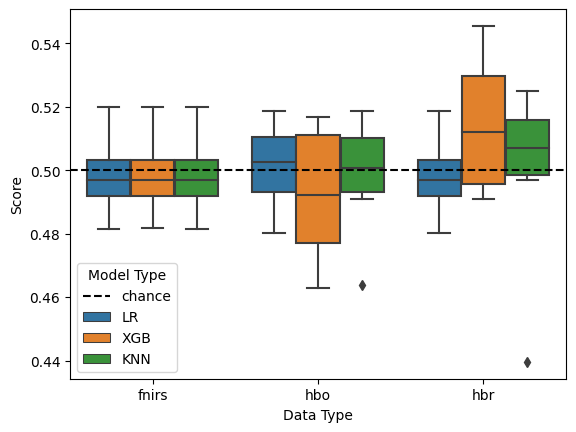

In [ ]:
all_scores = pd.DataFrame()

for df, dtype in zip([fnirs,hbo_all,hbr],['fnirs','hbo','hbr']):
    all_scores = all_scores.append(build_model(df,dtype))
    print(f'Done Processing {dtype} data')

print(all_scores)

plt.clf
plt.axhline(0.5, linestyle='--', color='k', label="chance")
sns.boxplot(x="Data Type", y="Score", hue="Model Type", data=all_scores)